In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import statistics
import pandas as pd
%matplotlib inline

In [2]:
## basic read in

In [3]:
def largest_several_mean(acc_list,count,neglect=5):
    acc_list.sort()
    sub_list = acc_list[-count-neglect:-neglect]
    my_mean = sum(sub_list) / len(sub_list)
    return my_mean

In [4]:
def min_loss_point(loss_list):
    loss_point = np.argmin(loss_list)
    return loss_point

In [5]:
def es_point(acc_list,p): # p means steps after the max index
    max_index=np.where(acc_list==np.amax(acc_list))
    max_index=max_index[0]+p
    return max_index[0]

In [6]:
def compute_last_mean(acc_list,window=100):
    sub_list = acc_list[-window:]
    last_mean = sum(sub_list) / len(sub_list)
    return last_mean

In [7]:
def windowed(s,half_window): # s in a list
    s_mean=[]
    s_var=[]
    window_size = half_window*2
    for i in range(len(s)-window_size+1):
        k = i + half_window
        s_sub=s[k-half_window:k+half_window]
        sub_mean=sum(s_sub)/len(s_sub)
        s_mean.append(sub_mean)
        sub_var=statistics.variance(s_sub)
        s_var.append(sub_var)
    return s_mean,s_var

In [8]:
def read_acc_mean(files,i,speed=1):
    fileset = pd.concat( [pd.read_csv(f,header=None,sep=' ',names=['loss','acc'])['acc'] for f in files], axis=1)
    normalset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==False], axis=1)
    normalset_mean = normalset.mean(axis=1)
    if speed==1:
        return normalset_mean   
    delayset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==True], axis=1)
    delayset_mean = delayset.mean(axis=1)
    return normalset_mean,delayset_mean
def read_loss_mean(files,i,speed=1):
    fileset = pd.concat( [pd.read_csv(f,header=None,sep=' ',names=['loss','acc'])['loss'] for f in files], axis=1)
    normalset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==False], axis=1)
    normalset_mean = normalset.mean(axis=1)
    if speed==1:
        return normalset_mean   
    delayset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==True], axis=1)
    delayset_mean = delayset.mean(axis=1)
    return normalset_mean,delayset_mean

In [9]:
## how to plot

In [10]:
def plot_line(i,k,basedir,result,lab,es=500,min_loss_stopping=False,addon=''):
    s1=np.load(os.path.join(basedir,result[k]))
    p=es_point(s1[2],es)
    if min_loss_stopping:
        p = min_loss_point(s1[1])
    s1_epo = [i+1 for i in s1[0][:p]]
    ax[i].plot(s1_epo,s1[2][:p], label=lab[k]+addon)

In [11]:
def plot_window_acc(i,k,half_window,basedir,result,lab,es=500,min_loss_stopping=False,addon=''):
    s1=np.load(os.path.join(basedir,result[k]))
    p=es_point(s1[2],es)
    if min_loss_stopping:
        p = min_loss_point(s1[1])
    (s_mean,s_varience)=windowed(s1[2][:p],half_window)
    s_epo=[i+1 for i in range(len(s_mean))]
    ax[i].plot(s_epo,s_mean, label=lab[k]+addon) # can also plot s_varience if want

In [12]:
def plot_file_acc(i,k,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt'):
    files = glob.glob(basedir +'/'+ node_dir[k]+ '/worker_nodes/*/'+filename)
    linelab = lab[k]
    if speed==1:
        normalset_mean = read_acc_mean(files,i,speed)
    else:
        normalset_mean,delayset_mean = read_acc_mean(files,i,speed)
    set_plt = [i+1 for i in range(len(normalset_mean))]
    ax[i].plot(set_plt,normalset_mean, label=linelab)
    print('normal')
    if speed!=1:
        set_plt = [i*speed+1 for i in range(len(delayset_mean))]
        ax[i].plot(set_plt,delayset_mean, label=linelab+'_delay')
        print('delayed')

In [13]:
def plot_file_window_acc(i,k,half_window,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt'):
    files = glob.glob(basedir +'/'+ node_dir[k]+ '/worker_nodes/*/'+filename)
    linelab = lab[k]
    if speed==1:
        normalset_mean = read_acc_mean(files,i,speed)
    else:
        normalset_mean,delayset_mean = read_acc_mean(files,i,speed)

    (s_mean,s_varience)=windowed(normalset_mean,half_window)
    s_epo=[i+1 for i in range(len(s_mean))]
    ax[i].plot(s_epo,s_mean, label=linelab)
    print('normal')
    if speed!=1:
        (s_mean,s_varience)=windowed(delayset_mean,half_window)
        s_epo=[i+1 for i in range(len(s_mean))]
        ax[i].plot(s_epo,s_mean, label=linelab+'_delay')
        print('delayed')


## Data & Size & Augument

In [14]:
basedir=os.path.join('Pilot_datasize&aug')
os.listdir(basedir)

['1000_central.batch50.es500.npy',
 '1000_central_aug.batch50.es500.npy',
 '1500_central.batch50.es500.npy',
 '1500_central_aug.batch50.es500.npy',
 '16000_central.batch50.es500.npy',
 '16000_central_aug.batch50.es500.npy',
 '2000_central.batch50.es500.npy',
 '2000_central_aug.batch50.es500.npy',
 '3000_central.batch50.es500.npy',
 '3000_central_aug.batch50.es500.npy',
 '4000_central.batch50.es500.npy',
 '4000_central_aug.batch50.es500.npy',
 '500_central.batch50.es500.npy',
 '500_central_aug.batch50.es500.npy',
 '600_central.batch60.es500.npy',
 '600_central_aug.batch60.es500.npy',
 '700_central.batch70.es500.npy',
 '700_central_aug.batch70.es500.npy',
 '8000_central.batch50.es500.npy',
 '8000_central_aug.batch50.es500.npy',
 '800_central.batch80.es500.npy',
 '800_central_aug.batch80.es500.npy',
 '900_central.batch90.es500.npy',
 '900_central_aug.batch90.es500.npy',
 'iid.10w.1000.loc1.earlystop500.20200518-121336.npy',
 'iid.10w.1500.loc1.earlystop500.20200518-163032.npy',
 'iid.10w.

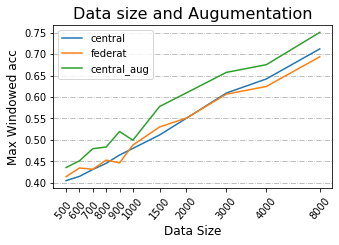

In [15]:

result=[

    '500_central.batch50.es500.npy',
    '600_central.batch60.es500.npy',
    '700_central.batch70.es500.npy',
    '800_central.batch80.es500.npy',
    '900_central.batch90.es500.npy',
    '1000_central.batch50.es500.npy',
    '1500_central.batch50.es500.npy',
    '2000_central.batch50.es500.npy',
    '3000_central.batch50.es500.npy',
    '4000_central.batch50.es500.npy',
    '8000_central.batch50.es500.npy',
    

    'iid.10w.500.loc1.earlystop500.20200518-120229.npy',
    'iid.10w.600.loc1.earlystop500.20200518-100100.npy',
    'iid.10w.700.loc1.earlystop500.20200519-063844.npy',
    'iid.10w.800.loc1.earlystop500.20200518-090515.npy',
    'iid.10w.900.loc1.earlystop500.20200518-055313.npy',
    'iid.10w.1000.loc1.earlystop500.20200518-121336.npy',
    'iid.10w.1500.loc1.earlystop500.20200518-163032.npy',
    'iid.10w.2000.loc1.earlystop500.20200518-152316.npy',
    'iid.10w.3000.loc1.earlystop500.20200519-030300.npy',
    'iid.10w.4000.loc1.earlystop500.20200501-020117.npy',
    'iid.10w.8000.loc1.earlystop500.20200518-103544.npy',
    
    '500_central_aug.batch50.es500.npy',
    '600_central_aug.batch60.es500.npy',
    '700_central_aug.batch70.es500.npy',
    '800_central_aug.batch80.es500.npy',
    '900_central_aug.batch90.es500.npy',
    '1000_central_aug.batch50.es500.npy',
    '1500_central_aug.batch50.es500.npy',
    '2000_central_aug.batch50.es500.npy',
    '3000_central_aug.batch50.es500.npy',
    '4000_central_aug.batch50.es500.npy',
    '8000_central_aug.batch50.es500.npy',    
    
]

lab = ['central','federat','central_aug']
half_window_size = 10

mean_list = []
max_list = []
point_minloss = []
max_means_list = []
variance_list = []
for res in result:
    s1=np.load(os.path.join(basedir,res))
    (s_mean,s_varience)=windowed(s1[2],half_window_size)
    
#     p = min_loss_point(s1[1])
#     point_minloss.append(s1[2][p])
    
#     mean = compute_last_mean(s_mean[:-300],window=100) # mean 
#     mean_list.append(mean)
    
#     var = compute_last_mean(s_varience[:-300],window=200) # var
#     variance_list.append(var)
    
    s_mean.sort()    
    myMax = s_mean[-1]
    max_list.append(myMax)
    
#     max_means = largest_several_mean(s_mean,count=20,neglect=5)
#     max_means_list.append(max_means)

    
class_list = [1,2,3,4,5,6,8,10,13,16,20]
myclass = len(class_list)
for i in [0,1,2]:
    plt.plot(class_list,max_list[i*myclass:i*myclass+myclass],label = lab[i]) # max--> the max windowed acc
#     plt.plot(class_list,mean_list[i*myclass:i*myclass+myclass],label = lab[i])  # mean--> the mean of the 200 windows after 
#     plt.plot(class_list,variance_list[i*myclass:i*myclass+myclass],label = lab[i])  # var
#     plt.plot(class_list,point_minloss[i*myclass:i*myclass+myclass],label = lab[i]) # point at min loss
#     plt.plot(class_list,max_means_list[i*myclass:i*myclass+myclass],label = lab[i]) # average of several biggest acc

    plt.gcf().set_size_inches(5, 3)
#     plt.ylim([0, 1.1])
    plt.xticks([1,2,3,4,5,6,8,10,13,16,20],['500  ','600  ','700  ','800  ','900  ','1000','1500','2000','3000','4000','8000'],rotation=50)
    plt.title('Data size and Augumentation',fontsize=16)
    plt.ylabel('Max Windowed acc',fontsize=12)    
    plt.xlabel('Data Size',fontsize=12)    
    plt.grid(axis="y",ls='-.')
    plt.legend()

## Pilot

In [19]:
basedir=os.path.join('Pilot_classes')
# os.listdir(basedir)

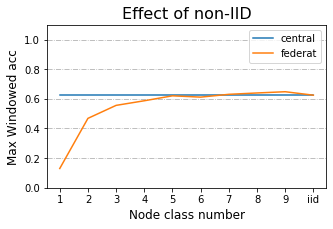

In [20]:

result=[
    
    '4000_central.batch50.npy',
    '4000_central.batch50.npy',
    '4000_central.batch50.npy',
    '4000_central.batch50.npy',
    '4000_central.batch50.npy',
    '4000_central.batch50.npy',
    '4000_central.batch50.npy',
    '4000_central.batch50.npy',
    '4000_central.batch50.npy',
    '4000_central.batch50.npy',

    
 '1c.10w.4000.loc1.earlystop500.20200510-163959.npy',
 '2c.10w.4000.loc1.earlystop500.20200501-072809.npy',
 '3c.10w.4000.loc1.earlystop500.20200511-025044.npy',
 '4c.10w.4000.loc1.earlystop500.20200511-210547.npy',
 '5c.10w.4000.loc1.earlystop500.20200501-024326.npy',
 '6c.10w.4000.loc1.earlystop500.20200512-002851.npy',
 '7c.10w.4000.loc1.earlystop500.20200511-194406.npy',
 '8c.10w.4000.loc1.earlystop500.20200512-084500.npy',
 '9c.10w.4000.loc1.earlystop500.20200512-054621.npy',
 'iid.10w.4000.loc1.earlystop500.20200501-020117.npy',

    
]

lab = ['central','federat']
half_window_size = 10

mean_list = []
max_list = []
point_minloss = []
max_means_list = []
for res in result:
    s1=np.load(os.path.join(basedir,res))
    (s_mean,s_varience)=windowed(s1[2][:500],half_window_size)
    
    p = min_loss_point(s1[1])
    point_minloss.append(s1[2][p])
    
    mean = compute_last_mean(s_mean,window=100) # mean 
    mean_list.append(mean)
    
    s_mean.sort()    
    myMax = s_mean[-1]
    max_list.append(myMax)
    
    max_means = largest_several_mean(s_mean,count=20,neglect=5)
    max_means_list.append(max_means)


class_list = [1,2,3,4,5,6,7,8,9,10]
myclass = len(class_list)
for i in [0,1]:

#     plt.plot(class_list,mean_list[i*myclass:i*myclass+myclass],label = lab[i])  # mean
    plt.plot(class_list,max_list[i*myclass:i*myclass+myclass],label = lab[i]) # max--> the max windowed acc
#     plt.plot(class_list,point_minloss[i*myclass:i*myclass+myclass],label = lab[i]) # point at min loss
#     plt.plot(class_list,max_means_list[i*myclass:i*myclass+myclass],label = lab[i]) # average of several biggest acc


    plt.gcf().set_size_inches(5, 3)
    plt.title('Effect of non-IID',fontsize=16)
    plt.xlabel('Node class number',fontsize=12)
    plt.xticks([1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,7,8,9,'iid'])
    plt.ylabel('Max Windowed acc',fontsize=12)
    plt.ylim([0, 1.1])
    plt.grid(axis="y",ls='-.')
    plt.legend()

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(12, 4))

fig.text(0.5, 0.01, 'Epoch', ha='center',fontsize=12)
fig.text(0.07, 0.5, 'Accuracy', va='center', rotation='vertical',fontsize=12)
fig.suptitle('Pilot test',fontsize=16)

result=[
 '1c.10w.4000.loc1.earlystop500.20200510-163959.npy',
 '2c.10w.4000.loc1.earlystop500.20200501-072809.npy',
 '3c.10w.4000.loc1.earlystop500.20200511-025044.npy',
 '4c.10w.4000.loc1.earlystop500.20200511-210547.npy',
 '5c.10w.4000.loc1.earlystop500.20200501-024326.npy',
 '6c.10w.4000.loc1.earlystop500.20200512-002851.npy',
 '7c.10w.4000.loc1.earlystop500.20200511-194406.npy',
 '8c.10w.4000.loc1.earlystop500.20200512-084500.npy',
 '9c.10w.4000.loc1.earlystop500.20200512-054621.npy',
 'iid.10w.4000.loc1.earlystop500.20200501-020117.npy',
 '4000_central.batch50.npy'
]
lab = [
    res[:-47] for res in result[:-1]
]
lab.append('central')


half_window_size=10


for j in range(2):
    for i in range(5):
        d = 5*j+i
        s1=np.load(os.path.join(basedir,result[d]))    
        (s_mean,s_varience)=windowed(s1[2][:500],half_window_size)
        s_epo=[i+half_window_size+1 for i in range(len(s_mean))]
        ax[j][i].plot(s_epo,s_mean, label=lab[d])
        
        s1=np.load(os.path.join(basedir,result[10]))    
        (s_mean,s_varience)=windowed(s1[2][:500],half_window_size)
        s_epo=[i+half_window_size+1 for i in range(len(s_mean))]
        ax[j][i].plot(s_epo,s_mean, label=lab[10])
        
        ax[j][i].set_ylim([0, 1.1])
        ax[j][i].grid(axis="y",ls='-.')
        ax[j][i].legend() 


## Data Dispersion

In [ ]:
basedir=os.path.join('DataDispersion')
# os.listdir(basedir)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12, 3))
# fig.text(0.5, 0.01, 'Epoch', ha='center',fontsize=12)
# fig.text(0.07, 0.5, 'Accuracy', va='center', rotation='vertical',fontsize=12)
fig.suptitle('Data Dispersion',fontsize=16)

result=[
    '2c.10w.4000_node_EVL.loc1.earlystop500.20200502-172929.npy',
    '2c.40w.4000.loc1.earlystop500.20200507-172304.npy',

    '5c.10w.4000_node_EVL.loc1.earlystop500.20200502-092327.npy',
    '5c.40w.4000.loc1.earlystop500.20200506-215910.npy',

    'iid.10w.4000_node_EVL.loc1.earlystop500.20200502-141431.npy',
    'iid.40w.4000.loc1.earlystop500.20200507-014322.npy'
    
       ]

lab=[
 '2c.10w',
 '2c.40w',
 '5c.10w',
 '5c.40w',
 'iid.10w',
 'iid.40w'
       ]

node_dir = [
    'evl2c',
    'dd2',
    
    'evl5c',
    'dd5',
    
    'evliid',
    'ddiid'
]

x = 2

for i in range(3):
    
    for j in range(x):
        k= i*x+j
        half_window=10
        
        plot_line(i,k,basedir,result,lab,es=500,min_loss_stopping=False,addon='')
        plot_window_acc(i,k,half_window,basedir,result,lab,es=500,min_loss_stopping=False,addon='')
        plot_file_acc(i,k,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt')
        plot_file_window_acc(i,k,half_window,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt')
        

    ax[1].set_xlabel('Epoch',fontsize=12)
    ax[i].set_ylim([0, 1.1])
#     ax[i].set_xlim([0, 5000])
    ax[i].grid(axis="y",ls='-.')
    ax[0].set_ylabel('Accuracy',fontsize=12)
    ax[i].legend() 

## Bad Node

In [ ]:
basedir=os.path.join('BadNode')
# os.listdir(basedir)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12, 3))

result=[
 '2c.10w.4000.plus1bad_each40.loc1.earlystop500.20200501-015142.npy',
 '2c.10w.4000.plus1bad_each400.loc1.earlystop500.20200501-031558.npy',
 '5c.10w.4000.plus1bad_each40.loc1.earlystop500.20200501-023155.npy',
 '5c.10w.4000.plus1bad_each400.loc1.earlystop500.20200501-004052.npy',
 '11d.10w.4000.plus1bad_each40.loc1.earlystop500.20200501-020918.npy',
 '11d.10w.4000.plus1bad_each400.loc1.earlystop500.20200501-060927.npy'
       ]

lab=[
 '2c.bad1_40',
 '2c.bad1_400',
 '5c.bad1_40',
 '5c.bad1_400',
 'iid.bad1_40',
 'iid.bad1_400'
       ]

node_dir = [
    'bad2c40',
    'bad2c400',
    'bad5c40',
    'bad5c400',
    'badiid40',
    'badiid400'
]

for i in range(3):    
    for j in range(2):
        k = i*2+j
        half_window_size=10
        
        plot_line(i,k,basedir,result,lab,es=500,min_loss_stopping=False,addon='')
        plot_window_acc(i,k,half_window,basedir,result,lab,es=500,min_loss_stopping=False,addon='')
        plot_file_acc(i,k,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt')
        plot_file_window_acc(i,k,half_window,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt')        
        

    ax[1].set_xlabel('Epoch',fontsize=12)
    ax[i].set_ylim([0, 1.1])
    ax[i].grid(axis="y",ls='-.')
    ax[0].set_ylabel('Accuracy',fontsize=12)
    ax[i].legend() 

## Local Steps

In [ ]:
basedir=os.path.join('LocalStep')
os.listdir(basedir)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18, 6))

result=[
    '2c.10w.4000.loc1.earlystop500.20200501-072809.npy',
    '2c.10w.4000.loc10.earlystop500.20200502-105042.npy',
    '2c.10w.4000.loc50.earlystop500.20200511-095914.npy',   
    '5c.10w.4000.loc1.earlystop500.20200501-024326.npy',
    '5c.10w.4000.loc10.earlystop500.20200501-203358.npy',
    '5c.10w.4000.loc50.earlystop500.20200504-130145.npy',
    'iid.10w.4000.loc1.earlystop500.20200501-020117.npy',
    'iid.10w.4000.loc10.earlystop500.20200502-151734.npy',
    'iid.10w.4000.loc50.earlystop500.20200508-064129.npy'
]

lab=[
    '2c.loc1',
    '2c.loc10',
    '2c.loc50',
    '5c.loc1',
    '5c.loc10',
    '5c.loc50',
    'iid.loc1',
    'iid.loc10',
    'iid.loc50'
]

node_dir = [
'loc2c1s',
'loc2c10s',
'loc2c50s',
'loc5c1s',
'loc5c10s',
'loc5c50s',
'lociid1s',
'lociid10s',
'lociid50s'
]


x = 3



for i in range(3):
    
    for j in range(x):
        k= i*x+j
        half_window=10
        
        plot_line(i,k,basedir,result,lab,es=500,min_loss_stopping=False,addon='')
        plot_window_acc(i,k,half_window,basedir,result,lab,es=500,min_loss_stopping=False,addon='')
        plot_file_acc(i,k,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt')
        plot_file_window_acc(i,k,half_window,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt')
        

    ax[i].set_xlabel('Epoch',fontsize=16)
    ax[i].set_ylim([0, 1.1])
    ax[i].grid(axis="y",ls='-.')
    ax[0].set_ylabel('Accuracy',fontsize=16)
    ax[i].legend() 

## Share Data

In [ ]:
basedir=os.path.join('ShareData')
os.listdir(basedir)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18, 6))

result = [
    '1c.10w.4000.share100.loc1.earlystop500.20200504-211245.npy',
    '1c.10w.4000.share100_epoiid.loc1.earlystop500.20200505-052608.npy',
    'iid.10w.4000.share100.loc1.earlystop500.20200505-111139.npy',
    
    '1c.10w.4000.share400.loc1.earlystop500.20200505-011914.npy',
    '1c.10w.4000.share400_epoiid.loc1.earlystop500.20200505-022211.npy',
    'iid.10w.4000.share400.loc1.earlystop500.20200505-113732.npy',
    
    '1c.10w.4000.share800.loc1.earlystop500.20200505-014623.npy',
    '1c.10w.4000.share800_epoiid.loc1.earlystop500.20200505-004219.npy',
    'iid.10w.4000.share800.loc1.earlystop500.20200505-125048.npy'
]
lab = [
    '1c.share100',
    '1c.share100_epoiid',
    'iid.share100',
    
    '1c.share400.loc1',
    '1c.share400_epoiid',
    'iid.share400',
    
    '1c.share800',
    '1c.share800_epoiid',
    'iid.share800',
]
node_dir = [
    'sdn1',
    'sde1',
    'iidsd1',
    
    'sdn4',
    'sde4',   
    'iidsd4',
    
    'sdn8',
    'sde8',
    'iidsd8'
]

central_result = [
    '100_central.batch50.npy',
    '400_central.batch50.npy',
    '800_central.batch50.npy'
]
central_lab = [
    '100_central',
    '400_central',
    '800_central'
]



for i in range(3):

#     plot_short_line(i,i,'zCentral',central_result,central_lab,1400)
#     plot_short_window_mean(i,i,half_window_size,'zCentral',central_result,central_lab,1400)
    
    for j in [0,1,2]:
        k= i*3+j
        
        half_window=10
        
        plot_line(i,k,basedir,result,lab,es=500,min_loss_stopping=False,addon='')
        plot_window_acc(i,k,half_window,basedir,result,lab,es=500,min_loss_stopping=False,addon='')
        plot_file_acc(i,k,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt')
        plot_file_window_acc(i,k,half_window,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt')
        

    ax[i].set_xlabel('Epoch',fontsize=16)
    ax[i].set_ylim([0, 1.1])
    ax[i].grid(axis="y",ls='-.')
    ax[0].set_ylabel('Accuracy',fontsize=16)
    ax[i].legend() 

## Late update in some node

In [ ]:
basedir=os.path.join('DelayUpdate')
# os.listdir(basedir)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18, 6))

# in order: dly8-30/12/3, dly20, dly32
result=[
    '2c.40w.4000.dly8.speed3.loc1.earlystop500.20200503-013135.npy',
    '2c.40w.4000.dly20.speed3.loc1.earlystop500.20200502-160017.npy',
    '2c.40w.4000.dly32.speed3.loc1.earlystop500.20200430-223516.npy',
    '2c.40w.4000.dly8.speed12.loc1.earlystop500.20200502-161123.npy',
    '2c.40w.4000.dly8.speed30.loc1.earlystop500.20200503-084238.npy',
        
   
    '5c.40w.4000.dly8.speed3.loc1.earlystop500.20200502-160044.npy',
    '5c.40w.4000.dly20.speed3.loc1.earlystop500.20200504-180902.npy',
    '5c.40w.4000.dly32.speed3.loc1.earlystop500.20200503-210047.npy', 
    '5c.40w.4000.dly8.speed12.loc1.earlystop500.20200502-171548.npy',
    '5c.40w.4000.dly8.speed30.loc1.earlystop500.20200502-182343.npy',
        
    
    'iid.40w.4000.dly8.speed3.loc1.earlystop500.20200502-193120.npy',
    'iid.40w.4000.dly20.speed3.loc1.earlystop500.20200503-002016.npy',
    'iid.40w.4000.dly32.speed3.loc1.earlystop500.20200502-184247.npy', 
    'iid.40w.4000.dly8.speed12.loc1.earlystop500.20200502-133739.npy',
    'iid.40w.4000.dly8.speed30.loc1.earlystop500.20200503-184146.npy', 
]

lab=[
    '2c.dly20%.speed3',
    '2c.dly50%.speed3',
    '2c.dly80%.speed3',
    '2c.dly20%.speed12',
    '2c.dly20%.speed30',
        
   
    '5c.dly20%.speed3',
    '5c.dly50%.speed3',
    '5c.dly80%.speed3', 
    '5c.dly20%.speed12',
    '5c.dly20%.speed30',
        
    
    'iid.dly20%.speed3',
    'iid.dly50%.speed3',
    'iid.dly80%.speed3', 
    'iid.dly20%.speed12',
    'iid.dly20%.speed30', 
]


node_dir = [
    'du2c1',
    'du2c2',
    'du2c3',
    'du2c4',
    'du2c5',
    'du5c1',
    'du5c2',
    'du5c3',
    'du5c4',
    'du5c5',
    'duiid1',
    'duiid2',
    'duiid3',
    'duiid4',
    'duiid5'
]

speed_list = [3,3,3,12,30,3,3,3,12,30,3,3,3,12,30]


for i in range(3):
    
    for j in [0]:
        
        k = i*5+j
        half_window_size=25
        speed = speed_list[k]
        print(speed)
        
        half_window=10
        
        plot_line(i,k,basedir,result,lab,es=500,min_loss_stopping=False,addon='')
        plot_window_acc(i,k,half_window,basedir,result,lab,es=500,min_loss_stopping=False,addon='')
        plot_file_acc(i,k,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt')
        plot_file_window_acc(i,k,half_window,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt')
        

    ax[i].set_xlabel('Epoch',fontsize=16)
    ax[i].set_ylim([0, 1.1])
    ax[i].grid(axis="y",ls='-.')
    ax[0].set_ylabel('Accuracy',fontsize=16)
    ax[i].legend() 

## Evaluate by node

In [ ]:
basedir=os.path.join('EvalTest')
# os.listdir(basedir)